In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import joblib                                                                                                                                            
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from scipy.stats import pearsonr
from collections import Counter

In [2]:
data = pd.read_table('../data-2/total4.15.txt',sep='\t',index_col=0)

data_gt= data.loc[:, data.columns.str.contains('BC|NT|MC|PC')].T
data_gt = data_gt.apply(pd.to_numeric)
data_gt = data_gt.drop(index=['BC5.1', 'BC5.3'])
data_gt = data_gt.apply(pd.to_numeric)
data_gt.fillna(0, inplace=True) 
data_gt.columns = data['ID']
# data_gt

data_fjg= data.loc[:, ~data.columns.str.contains('BC|NT|MC|PC')].T
data_fjg.columns = data_fjg.iloc[0]
data_fjg = data_fjg[1:]
data_fjg = data_fjg.sort_index()
data_fjg = data_fjg.replace("#DIV/0!", 0)
data_fjg = data_fjg.apply(pd.to_numeric)
data_fjg.fillna(0, inplace=True) 
# data_fjg

from scipy.stats import pearsonr


pearson_corr_values = []
for i in range(len(data_fjg)):
    corr_values = []
    for j in range(len(data_gt)):
        corr, _ = pearsonr(data_fjg.iloc[i], data_gt.iloc[j])
        corr_values.append(corr)
    pearson_corr_values.append(corr_values)


pearson_corr_matrix = pd.DataFrame(pearson_corr_values, index=data_fjg.index, columns=data_gt.index)
pearson_corr_matrix['sum'] = pearson_corr_matrix.sum(axis=1)
# pearson_corr_matrix


pearson_corr_matrix['label'] = np.where(pearson_corr_matrix['sum'] > 1.5, 1, 0) 
# similarity_matrix
len(pearson_corr_matrix[pearson_corr_matrix['label'] == 1])


data = pd.concat([data_fjg, data_gt])
data = data.loc[:, (data != 0).any(axis=0)]
X = data

Y = pearson_corr_matrix['label'].tolist() + [1] * len(data_gt)
Y = np.array(Y)

print(X.shape,Y.shape) 
Counter(Y)


(89, 2537) (89,)


Counter({0: 45, 1: 44})

In [3]:
X  = Normalizer().fit_transform(X)
# X  = StandardScaler().fit_transform(X)
X  = MinMaxScaler().fit_transform(X)

In [4]:

rfc = SVC(C=0.0255,kernel='linear', probability=True,random_state=42)

n = 4
sfm = SelectFromModel(rfc,max_features =n) 
X_sn_new = sfm.fit_transform(X, Y)
print(X_sn_new.shape)

non_zero_indices = sfm.get_support(indices=True)
non_zero_indices = non_zero_indices.tolist()
all_f = data.columns.tolist()
feature = [all_f[i] for i in non_zero_indices]
print("Selected Features:", feature)
for i in feature:
    print(i)

X_k = X[:, non_zero_indices]
print(X_k.shape,Y.shape)

(89, 4)
Selected Features: ['622-78-6', '60-12-8', '104-46-1', '98-85-1']
622-78-6
60-12-8
104-46-1
98-85-1
(89, 4) (89,)


In [12]:

# # new = non_zero_indices[1:]
# # new = non_zero_indices[:1] + non_zero_indices[2:]
# # new = non_zero_indices[:2] + non_zero_indices[3:]
# # new = non_zero_indices[:3] + non_zero_indices[4:]
# # new = non_zero_indices[:4] + non_zero_indices[5:]
# # new = non_zero_indices[:5] + non_zero_indices[6:]
# new = non_zero_indices[:6] + non_zero_indices[7:]

# # new = non_zero_indices[:7] + non_zero_indices[8:]
# # new = non_zero_indices[:8] + non_zero_indices[9:]
# X_k = X[:, new]
# print(X_k.shape,Y.shape)

# feature = [all_f[i] for i in new]
# print(len(feature),feature)
# new,non_zero_indices

In [5]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
auc_scores = []
recall = []
precision = []
tpr_list = []
fpr_list = []

accuracies_train = []
f1_scores_train = []
auc_scores_train = []
recall_train = []
precision_train = []
tpr_list_train = []
fpr_list_train = []


for train_idx, test_idx in cv.split(X_k, Y):
    X_train, X_test = X_k[train_idx], X_k[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    rfc.fit(X_train, Y_train)
    #train
    X_pred = rfc.predict(X_train)
    accuracy = accuracy_score(Y_train, X_pred)
    re = metrics.recall_score(Y_train, X_pred)
    pr = metrics.precision_score(Y_train, X_pred)
    f1 = f1_score(Y_train, X_pred)
    auc1 = roc_auc_score(Y_train, rfc.predict_proba(X_train)[:,1])
    fpr, tpr, _ = roc_curve(Y_train,  rfc.predict_proba(X_train)[:,1])

    accuracies_train.append(accuracy)
    f1_scores_train.append(f1)
    auc_scores_train.append(auc1)
    recall_train.append(re)
    precision_train.append(pr)
    tpr_list_train.append(tpr)
    fpr_list_train.append(fpr)

    #test
    Y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    re = metrics.recall_score(Y_test, Y_pred)
    pr = metrics.precision_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    auc1 = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:,1])
    fpr, tpr, _ = roc_curve(Y_test,  rfc.predict_proba(X_test)[:,1])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    accuracies.append(accuracy)
    recall.append(re)
    precision.append(pr)
    f1_scores.append(f1)
    auc_scores.append(auc1)


for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies_train, recall_train,f1_scores_train, auc_scores_train), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')


average_accuracy = sum(accuracies_train) / len(accuracies_train)
average_recall = sum(recall_train) / len(recall_train)
average_f1 = sum(f1_scores_train) / len(f1_scores_train)
average_auc = sum(auc_scores_train) / len(auc_scores_train)
average_precision = sum(precision_train) / len(precision_train)


print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.8875, Recall = 0.8250,F1 Score = 0.8800, AUC = 0.5000
Fold 2: Accuracy = 0.9000, Recall = 0.8500,F1 Score = 0.8947, AUC = 0.5000
Fold 3: Accuracy = 0.8875, Recall = 0.8500,F1 Score = 0.8831, AUC = 0.1325
Fold 4: Accuracy = 0.8875, Recall = 0.8500,F1 Score = 0.8831, AUC = 0.0975
Fold 5: Accuracy = 0.8875, Recall = 0.8500,F1 Score = 0.8831, AUC = 0.5000
Fold 6: Accuracy = 0.5125, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0954
Fold 7: Accuracy = 0.5125, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0972
Fold 8: Accuracy = 0.5125, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0513
Fold 9: Accuracy = 0.5125, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0475
Fold 10: Accuracy = 0.5062, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.9530
Average Accuracy = 0.7006
Average Recall = 0.4225
Average Precision = 0.4644
Average F1 Score = 0.4424
Average AUC = 0.2974


/data/public/dulin/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/public/dulin/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/public/dulin/miniconda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/public/dulin/miniconda/lib/python3.9/site-packages/sklearn/metrics/_cl

In [6]:

for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies, recall,f1_scores, auc_scores), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')

average_accuracy = sum(accuracies) / len(accuracies)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_scores) / len(f1_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_precision = sum(precision) / len(precision)
print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.6667, Recall = 1.0000,F1 Score = 0.7273, AUC = 0.5000
Fold 2: Accuracy = 0.7778, Recall = 0.7500,F1 Score = 0.7500, AUC = 0.5000
Fold 3: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.0000
Fold 4: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.0500
Fold 5: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.5000
Fold 6: Accuracy = 0.4444, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.1250
Fold 7: Accuracy = 0.4444, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0000
Fold 8: Accuracy = 0.4444, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0000
Fold 9: Accuracy = 0.4444, Recall = 0.0000,F1 Score = 0.0000, AUC = 0.0500
Fold 10: Accuracy = 0.5000, Recall = 0.0000,F1 Score = 0.0000, AUC = 1.0000
Average Accuracy = 0.6389
Average Recall = 0.4000
Average Precision = 0.4321
Average F1 Score = 0.4049
Average AUC = 0.2725


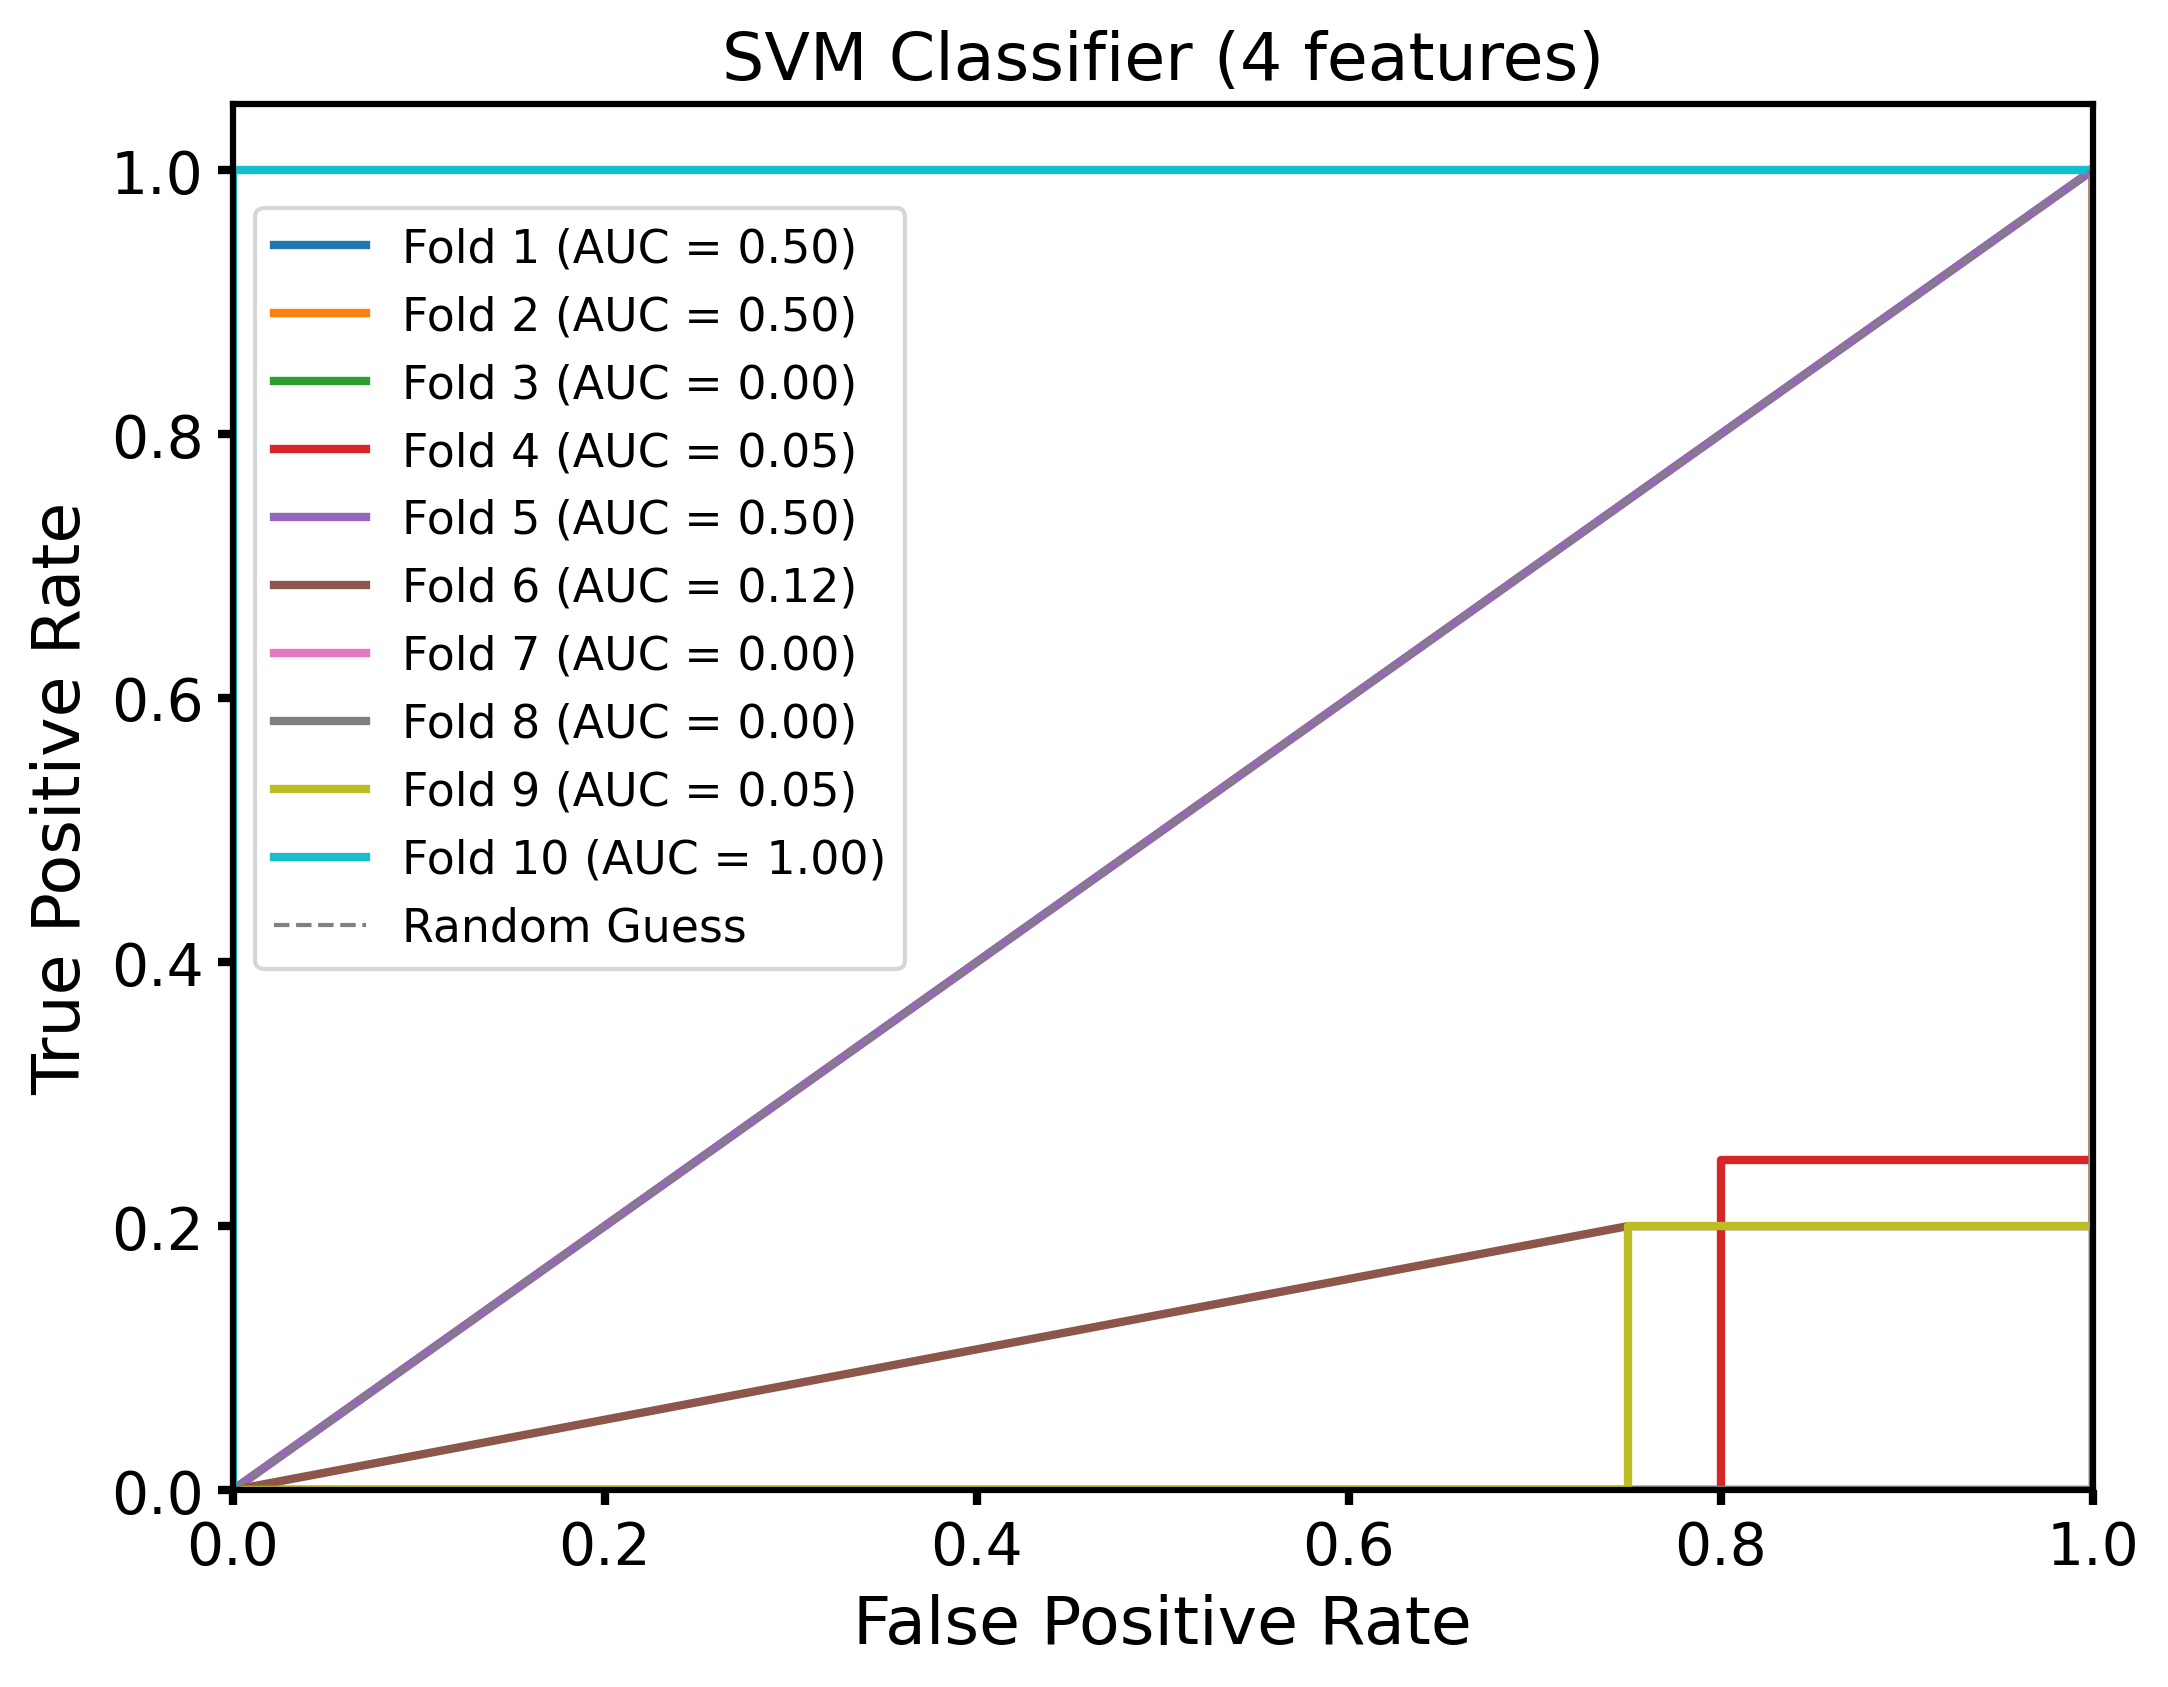

In [25]:

plt.figure(figsize=(8, 6),dpi=300)
for i, (tpr, fpr, roc_auc) in enumerate(zip(tpr_list, fpr_list, auc_scores), 1):
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1,label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SVM Classifier (4 features)', fontsize=16)
plt.legend(loc='upper left', fontsize=11, bbox_to_anchor=(0.125, 0.835), bbox_transform =plt.gcf().transFigure)



plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

plt.gca().tick_params(axis='both', which='major', width=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("../code-2/result/SVM-4F-ROC.pdf")
plt.savefig("../code-2/result/SVM-4F-ROC.png")
plt.show()

In [47]:
joblib.dump(rfc, "../code-2/result/SVM_Classifier-4f.joblib") #save model

['/data/public/dulin/fwwz/code-2/result/SVM_Classifier-4f.joblib']